In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
from scipy import signal
from scipy.optimize import curve_fit
import subprocess
import shutil

pi = np.pi
clight = 299792458
E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
clight = 299792458

In [24]:
def func_exp_fit(x, a, b, c):
    return a*np.exp(b*x)+c

In [25]:
def get_folders(folders,cwd):
    new_folders = []
    for folder in folders:
        if os.path.isdir(os.path.join(cwd,folder)):
            new_folders.append(folder)
    return new_folders

In [26]:
def get_n_sample(data,stride):
    n = 0
    i = data[0]
    while data[n*stride]>=i:
        i = data[n*stride]
        n+=1
        if n*stride >=len(data):
            break
    return n

In [27]:
working_folder = '3rd_fb_g3/'
home0 = os.getcwd()
home1 = os.path.join(home0,working_folder)
cwd = os.path.join(home0,working_folder)


In [28]:
folders = os.listdir(cwd)
new_folders = get_folders(folders,cwd);
new_folders = np.sort(new_folders);

#get the starting index in the folder name string that represent the substring of current
i_start_current = new_folders[0].find('Idc')+3

#get the starting index in the folder name string that represent the substring of loading angle
i_start_thetaL = new_folders[0].find('ThetaL')+6

current = [float(folder[folder.find('Idc')+3:folder.find('Idc')+3+4]) for folder in new_folders]
thetaL = [float(folder[folder.find('ThetaL')+6:folder.find('ThetaL')+6+3]) for folder in new_folders]


In [29]:
new_folders

array(['0000nmacro14400_nBin99_Idc2.50A_ThetaL10.0degree',
       '0000nmacro1_nBin297_Idc2.50A_ThetaL10.0degree'], dtype='<U48')

In [30]:
nThetaL = get_n_sample(thetaL,1)
nIb = get_n_sample(current,nThetaL)
current = current[::nThetaL]
thetaL = thetaL[:nThetaL]

In [31]:
inputfile = 'input.txt'
temppath = os.path.join(cwd,new_folders[0])
inputfile = os.path.join(temppath,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])


In [32]:
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
nTurns = int(tempinput['n_turns'][0])
nDynamic = int(tempinput['n_dynamicOn'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
detune_final = np.array([i for i in tempinput['detune_final']])

step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
n_record = nTurns/step
clight = 299792458
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
t_rad_long = tempinput['t_rad_long'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF != 1 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_final)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0


print(Qs)


0.054161923014470634


0000nmacro14400_nBin99_Idc2.50A_ThetaL10.0degree
[ 5.32464943  0.1617917  -9.75815117]
[[ 1.23759881e+00 -8.40679663e-03 -4.81909961e+00]
 [-8.40679663e-03  5.75885874e-05  3.15042759e-02]
 [-4.81909961e+00  3.15042759e-02  2.83696116e+01]]


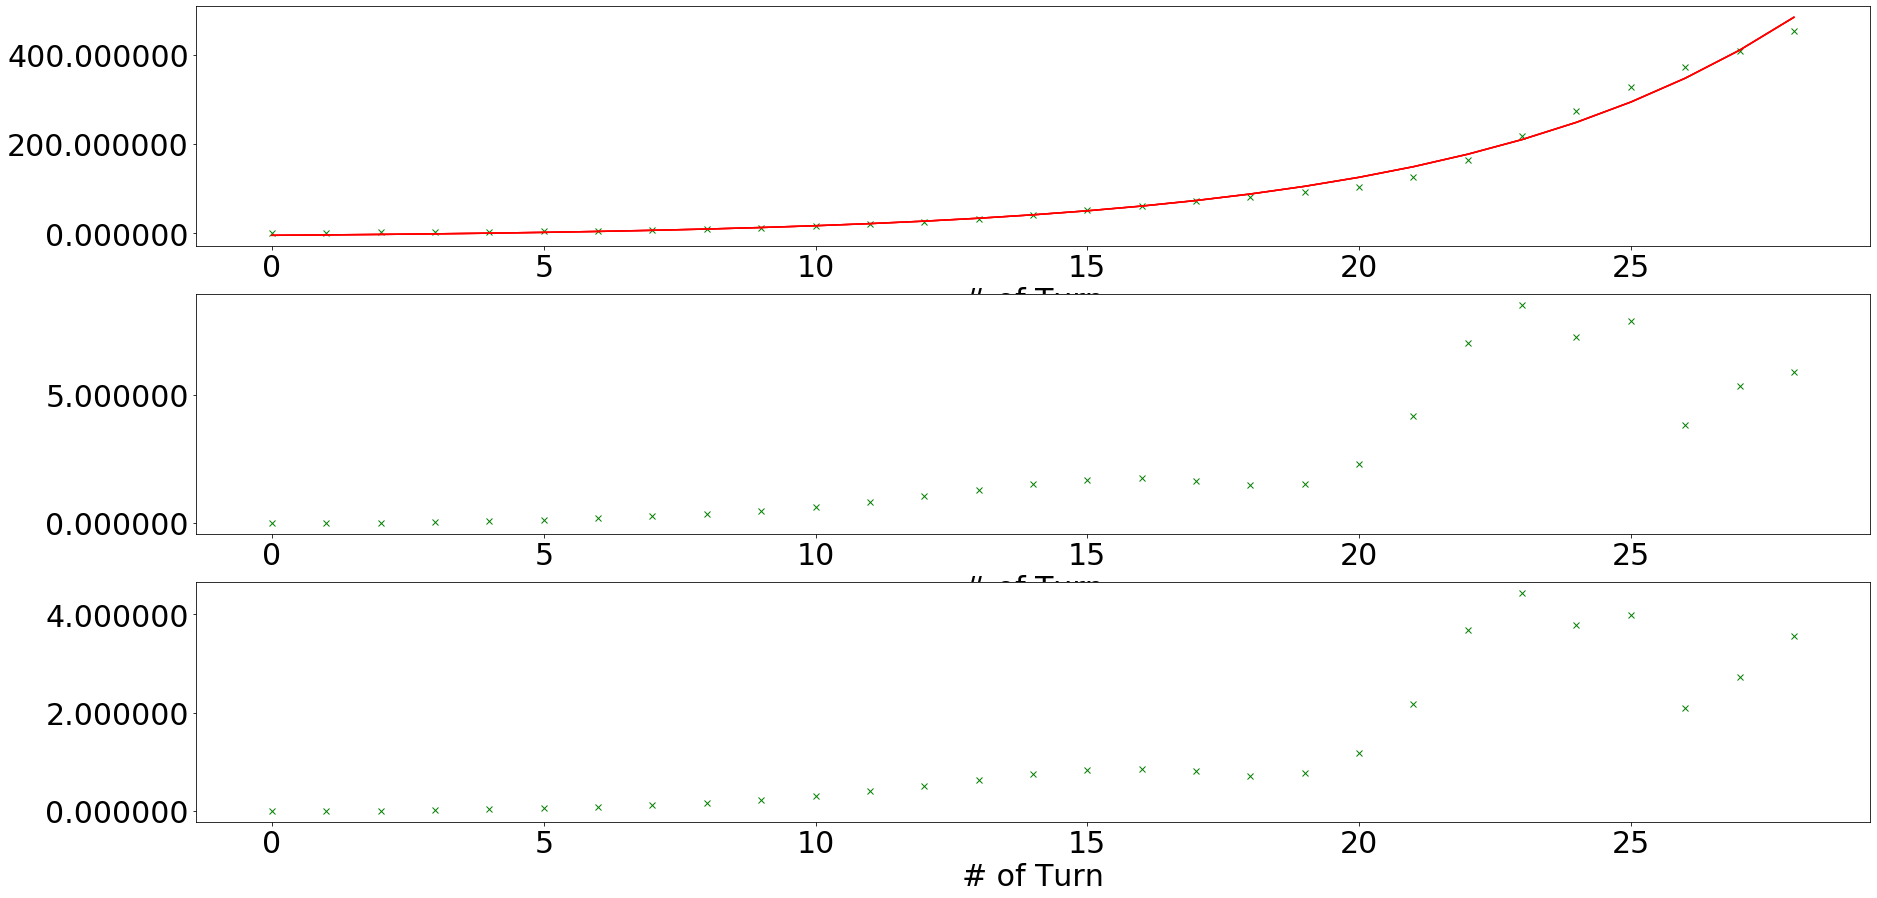

0000nmacro1_nBin297_Idc2.50A_ThetaL10.0degree
[ 4.02164451  0.23000151 -1.36058708]
[[ 6.17762966e-01 -7.74712187e-03 -2.51263015e+00]
 [-7.74712187e-03  9.79527057e-05  3.03115816e-02]
 [-2.51263015e+00  3.03115816e-02  1.58216863e+01]]


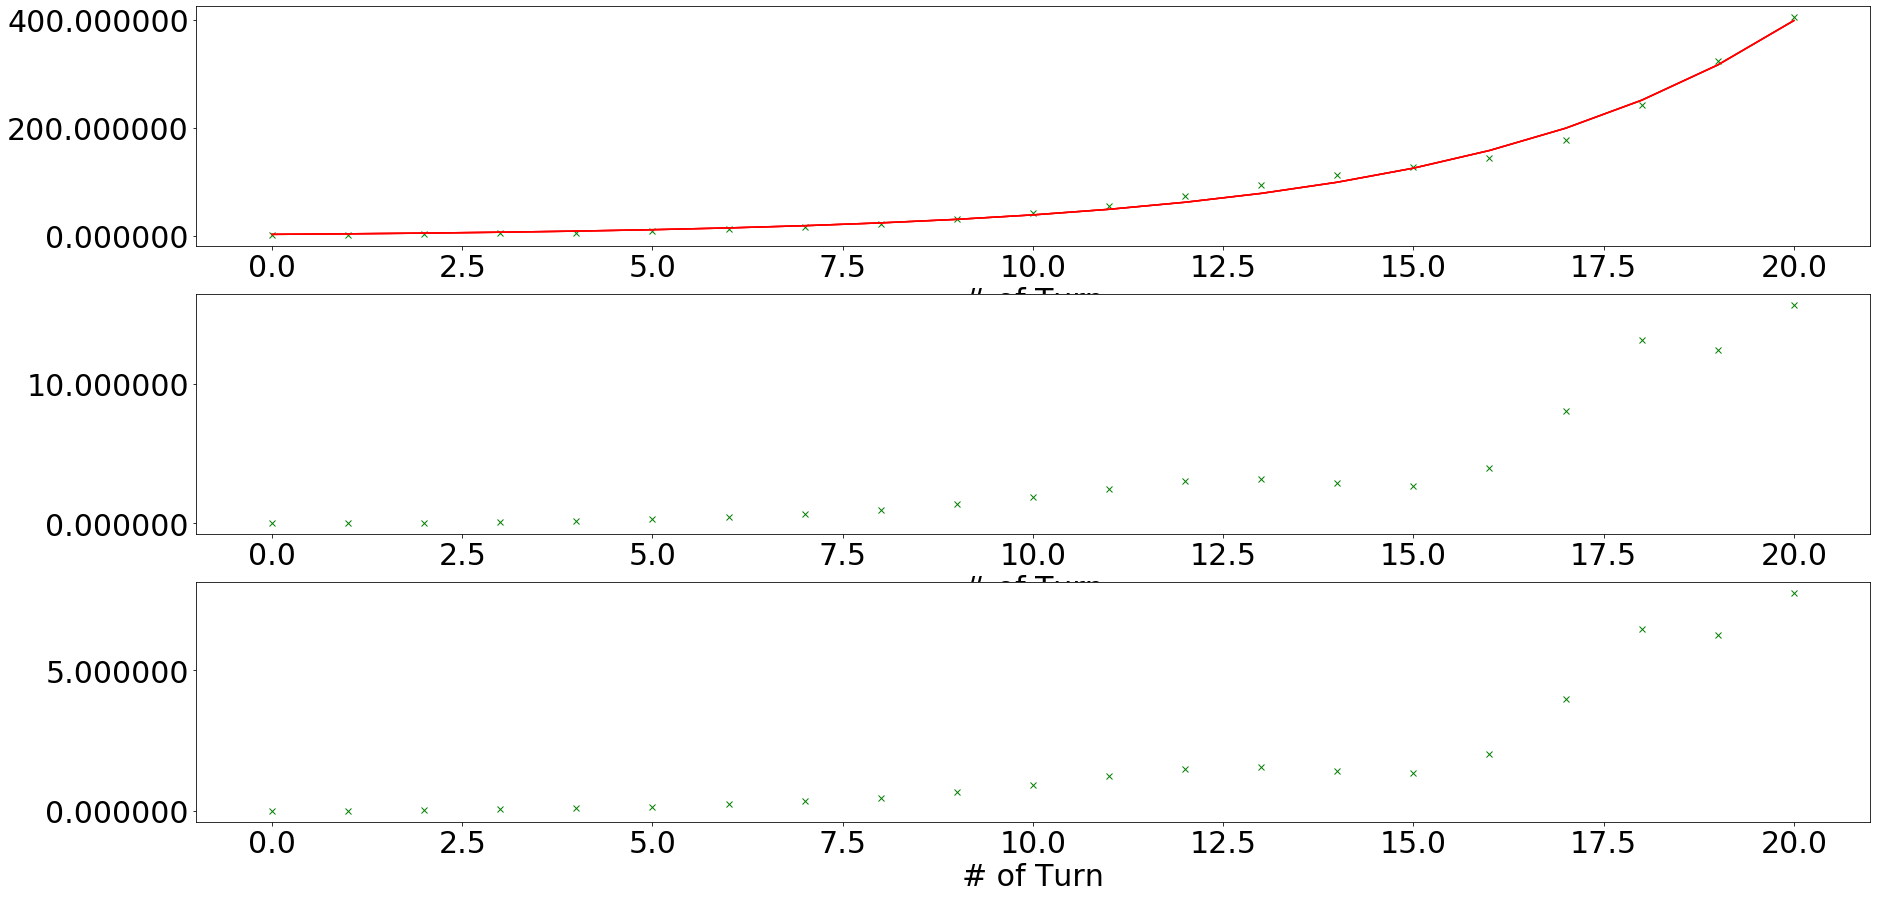

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

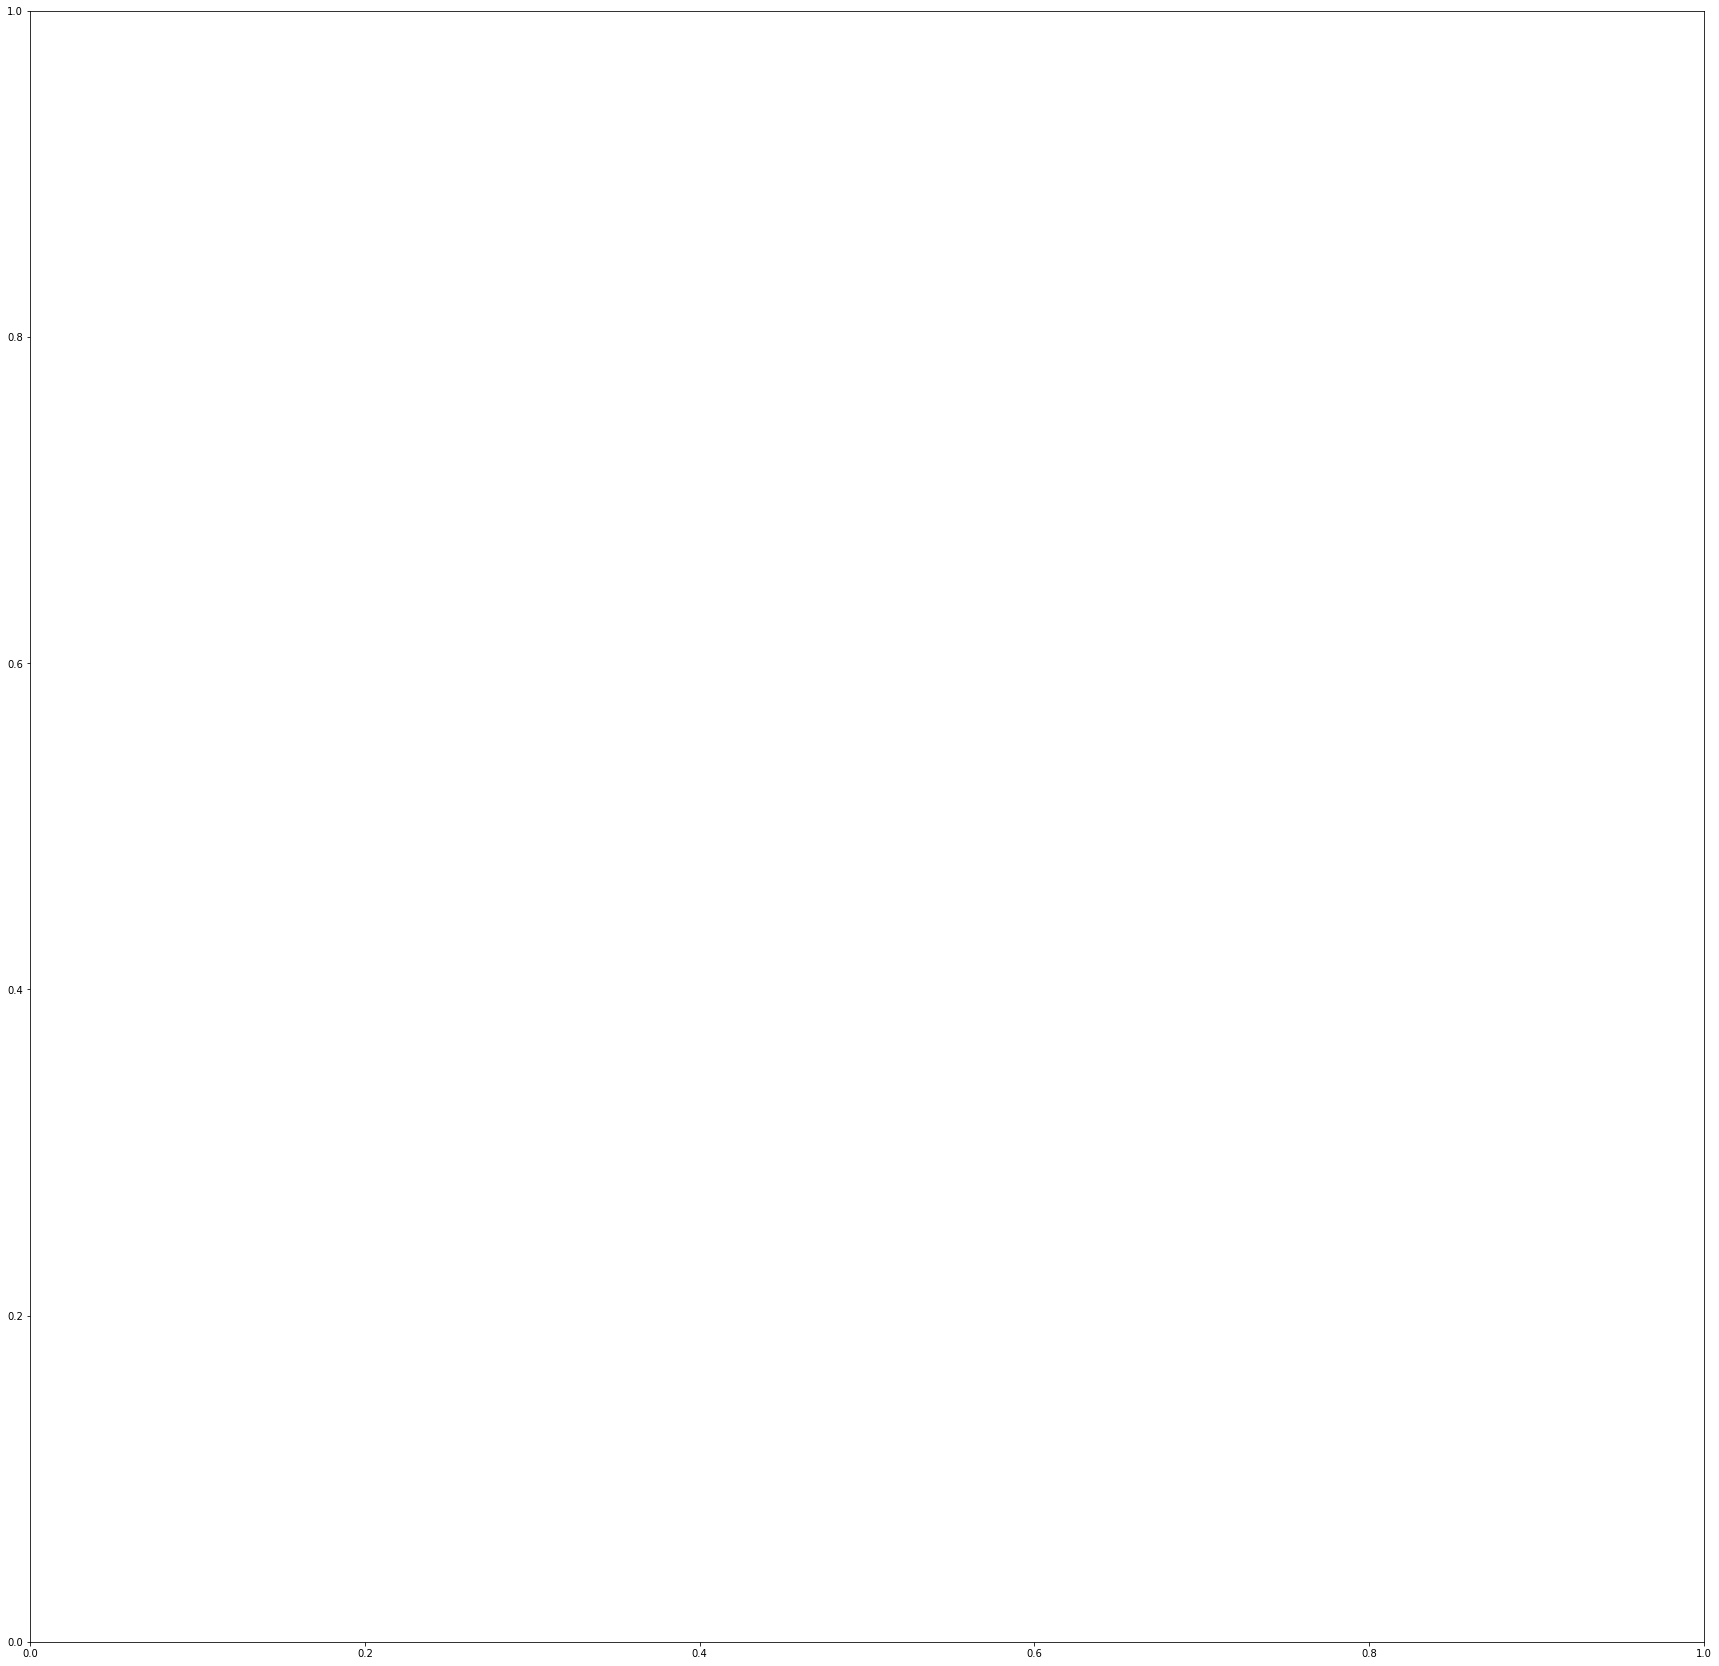

In [33]:
# get the fitted growth rate
# first, find the turn number where the mu=1 mode amplitude exceed certain value
def get_the_turn_number(c,value):
    for i in range(len(c)):
        if c[i]>=value:
            return i
    return i

inputfn = 'input.txt'
datafn = 'data.bin'

N_mode = 3 # number of mode to look
mu_danger = 0 # the mode we think is the most dangers

centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
q_guess = 0.01
qidx = 0
folders.sort()
for folder in new_folders:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    if nRF ==1:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
    elif nRF == 2 :
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

# calculate the components
    sincomp = []
    coscomp = []
    a = np.ndarray([N_mode,nTurns])
    b = np.ndarray([N_mode,nTurns])
    c = np.ndarray([N_mode,nTurns])
    
    value = 500 # the value where we stop the plotting
    idx = 0
    
    fig1,axes1 = plt.subplots(N_mode,1)
    fig1.set_figheight(15)
    fig1.set_figwidth(30)
    
    for mu in range(N_mode):
        sincomp.append(np.sin(mu*2*pi*f0*np.array(centroids)))
        coscomp.append(np.cos(mu*2*pi*f0*np.array(centroids)))
        for i in range(nTurns):
            a[mu][i] = np.sum(sincomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(sincomp[mu])
            b[mu][i] = np.sum(coscomp[mu]*M1_2[i*nBunch:(i+1)*nBunch])/len(coscomp[mu])
        c[mu] = np.sqrt(np.array(a[mu])**2+np.array(b[mu])**2)
        
    idx = get_the_turn_number(c[mu_danger],value)
# fit the growth rate
    
    
    rng1 = nDynamic
    rng2 = idx
    if rng1>rng2:
        rng1 = 0
    cNew = c[mu_danger][rng1:rng2]
    turn_temp = range(rng2-rng1)
    # the guessed value of growth rate
    if qidx<=25:
        q_guess = 0.5
    else:
        q_guess = 0.3
    popt, pcov = curve_fit(func_exp_fit, turn_temp, \
                           cNew,bounds=([-cNew[0]*100,-q_guess,-cNew[0]*100], [cNew[0]*100, q_guess, cNew[0]*100]),\
                           maxfev=20000000)
    print(popt)
    print(pcov)
    qs[qidx] = popt[1]
    qidx+=1
    c_fit =  popt[0]*np.exp(popt[1]*turn_temp)+popt[2]
    for mu in range(N_mode):
        axes1[mu].plot(c[mu][rng1:rng2],'gx')
        axes1[mu_danger].plot(c_fit,'r-')
        axes1[mu].tick_params(labelsize=50)

        axes1[mu].set_xlabel('# of Turn',fontsize=30)

        axes1[mu].tick_params(labelsize=30)
        y_labels = axes1[mu].get_yticks()
        axes1[mu].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.6f'))

    fn_after = os.path.join(cwd,'CB_Modes.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(30)
fig1.set_figwidth(30)
axes1.plot(current,qs,'rx-')
plt.show()
#taus = T0/qs
os.chdir(home0)

ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

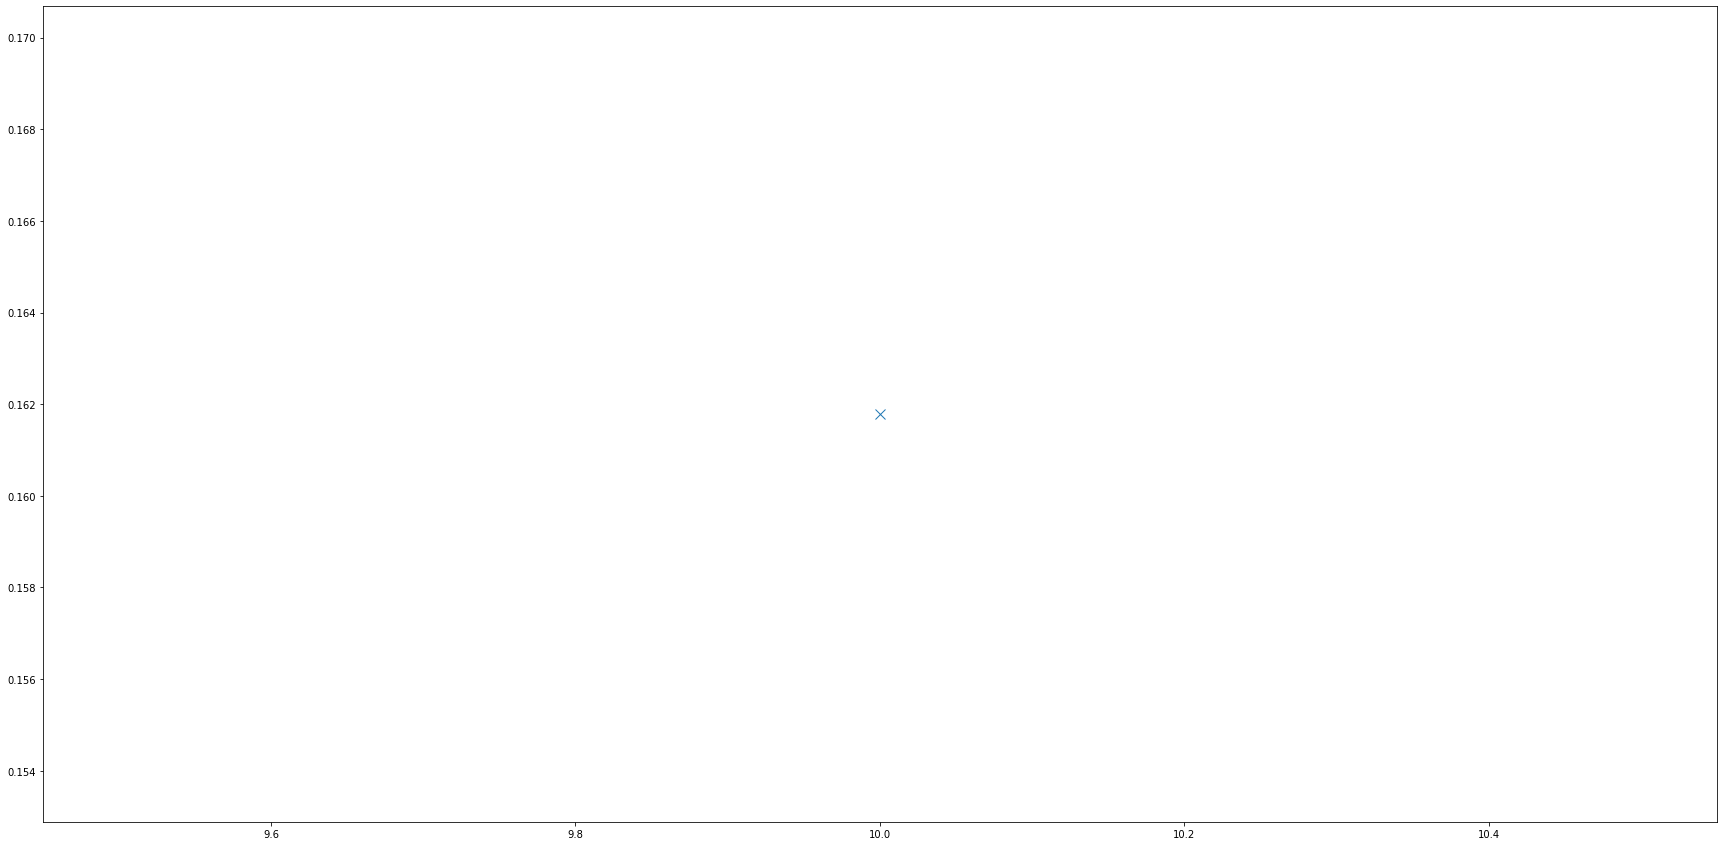

In [22]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
Ibstart= 0
Ibend = 7#int(len(qs)/nThetaL)
legends = [str(i) for i in current[Ibstart:Ibend]]

for i in range(Ibstart,Ibend):
    rng1 = 0
    rng2 = len(thetaL)
    axes1.plot(thetaL[rng1:rng2],qs[i*nThetaL+rng1:i*nThetaL+rng2],'x-', ms=10)
axes1.axhline(y=0)
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)

axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
axes1.legend(legends,prop={'size': 30})
fn_growth_rate = os.path.join(cwd,'growth_rate_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [13]:
qs[i:int(len(qs)/nThetaL)*nIb:nIb]

array([], dtype=float64)

In [155]:
os.chdir(home0)
cwd = os.getcwd()
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
legends2 = [str(i) for i in thetaL]

for i in range(len(thetaL)):
    axes1.plot(current[:int(len(qs)/nThetaL)],qs[i:int(len(qs)/nThetaL)*nIb:nIb],'rx-')
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.legend(legends2,prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (8,)

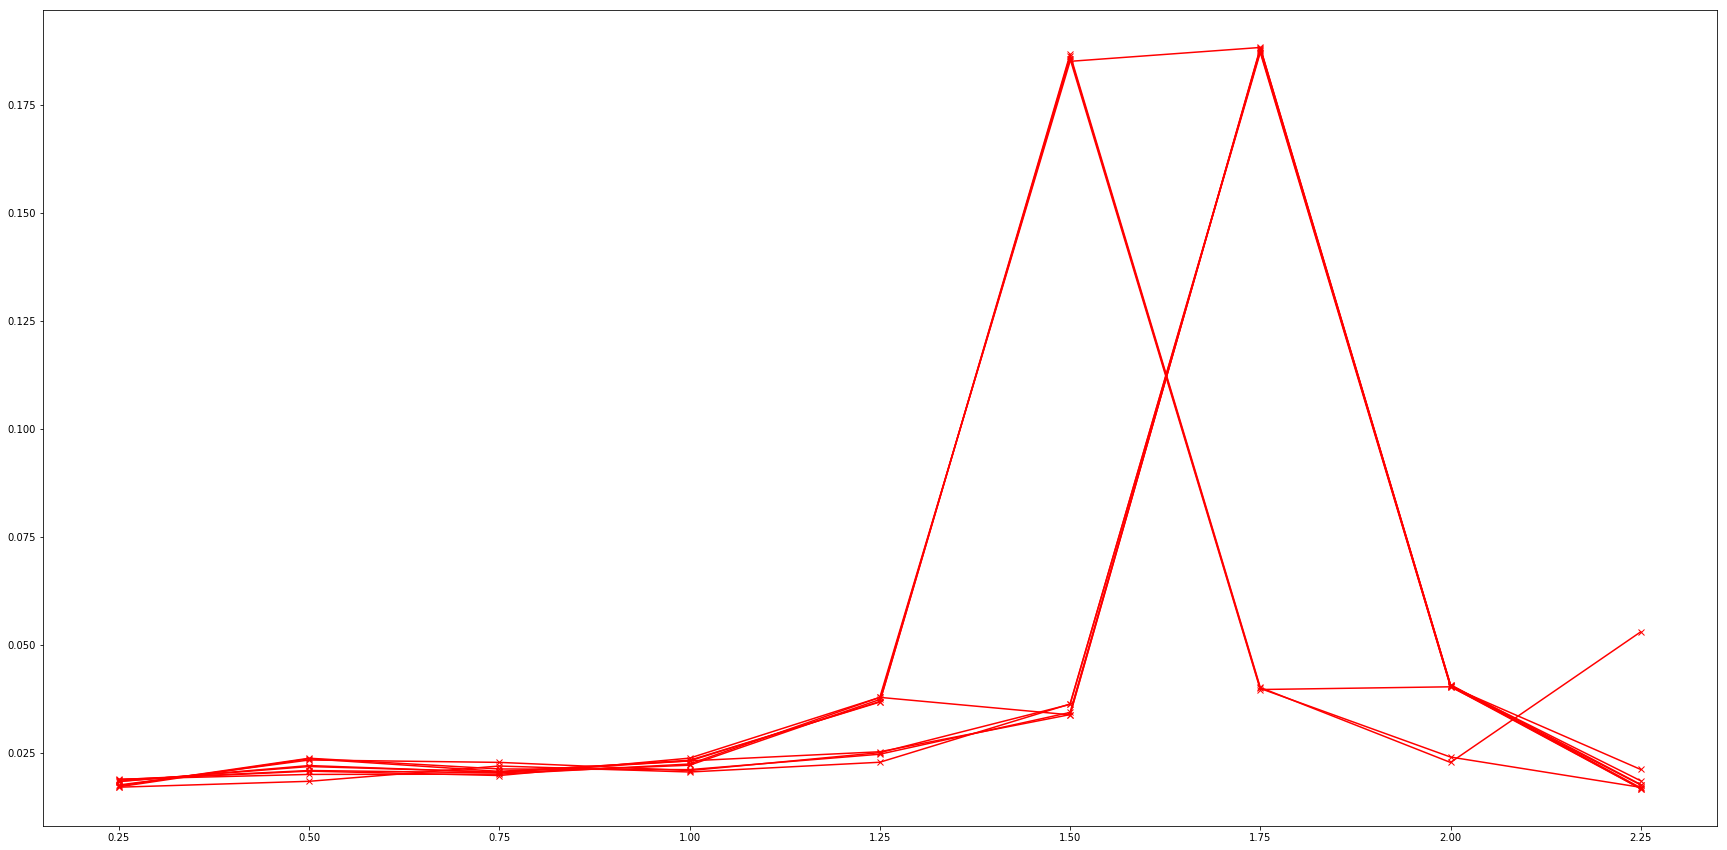

In [156]:
plt.show()

In [34]:
# get analitical number from simple formula (Chao's book)
def Zparallel(Rsh, QL, omega0, omega):
    return Rsh*omega/(omega+1j*QL*(omega0-omega**2/omega0)) # using the convention from A. Chao's book
# Small tune shift approximation
r0 = (1*1.6e-19)**2/(1*9.10938356e-31*3e8*3e8)

pmax = 1*nBunch # number of samples in frequency domain

#only look at the mu=? mode
mu = 0
delta_omega_Re = np.zeros(len(new_folders))
delta_omega_Im = np.zeros(len(new_folders))
ps = np.array([float(i) for i in range(-pmax,pmax)])

p_M_omega0 = ps*nBunch*2*np.pi*f0

omegas = Qs*2*pi*f0
qidx=0

for folder in new_folders[:]:
    #print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    if nRF ==1:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
    elif nRF == 2 :
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    
    # for the calculation of real part of Omega

    omegas1 = ((ps*nBunch+mu)*2*np.pi*f0+omegas) # using incoherent omegas for approximation
    Zs1 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas1) for i in range(nRF)])
    factor1 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*omegas) # using incoherent omegas for approximation
    deltaOmegaRe = -factor1*np.sum(omegas1*np.imag(Zs1))
    # for the calculation of the imaginary part of Omega
    omegas2 = ((ps*nBunch+mu)*2*np.pi*f0+(omegas))

    factor2 = nBunch*NperBunch*r0*eta/(2*Gamma0*T0**2*(omegas))

    Zs2 = np.array([Zparallel(R[i],QL[i],omegac[i],omegas2) for i in range(nRF)])
    deltaOmegaIm = factor2*np.sum(omegas2*np.real(Zs2))
    delta_omega_Re[qidx] = deltaOmegaRe
    delta_omega_Im[qidx] = deltaOmegaIm
    print(deltaOmegaRe/2/pi,deltaOmegaIm)
    qidx+=1
os.chdir(home0)
cwd = os.getcwd()

-2365.4085664034014 1140.6417799206936
-2365.4085664034014 1140.6417799206936


ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

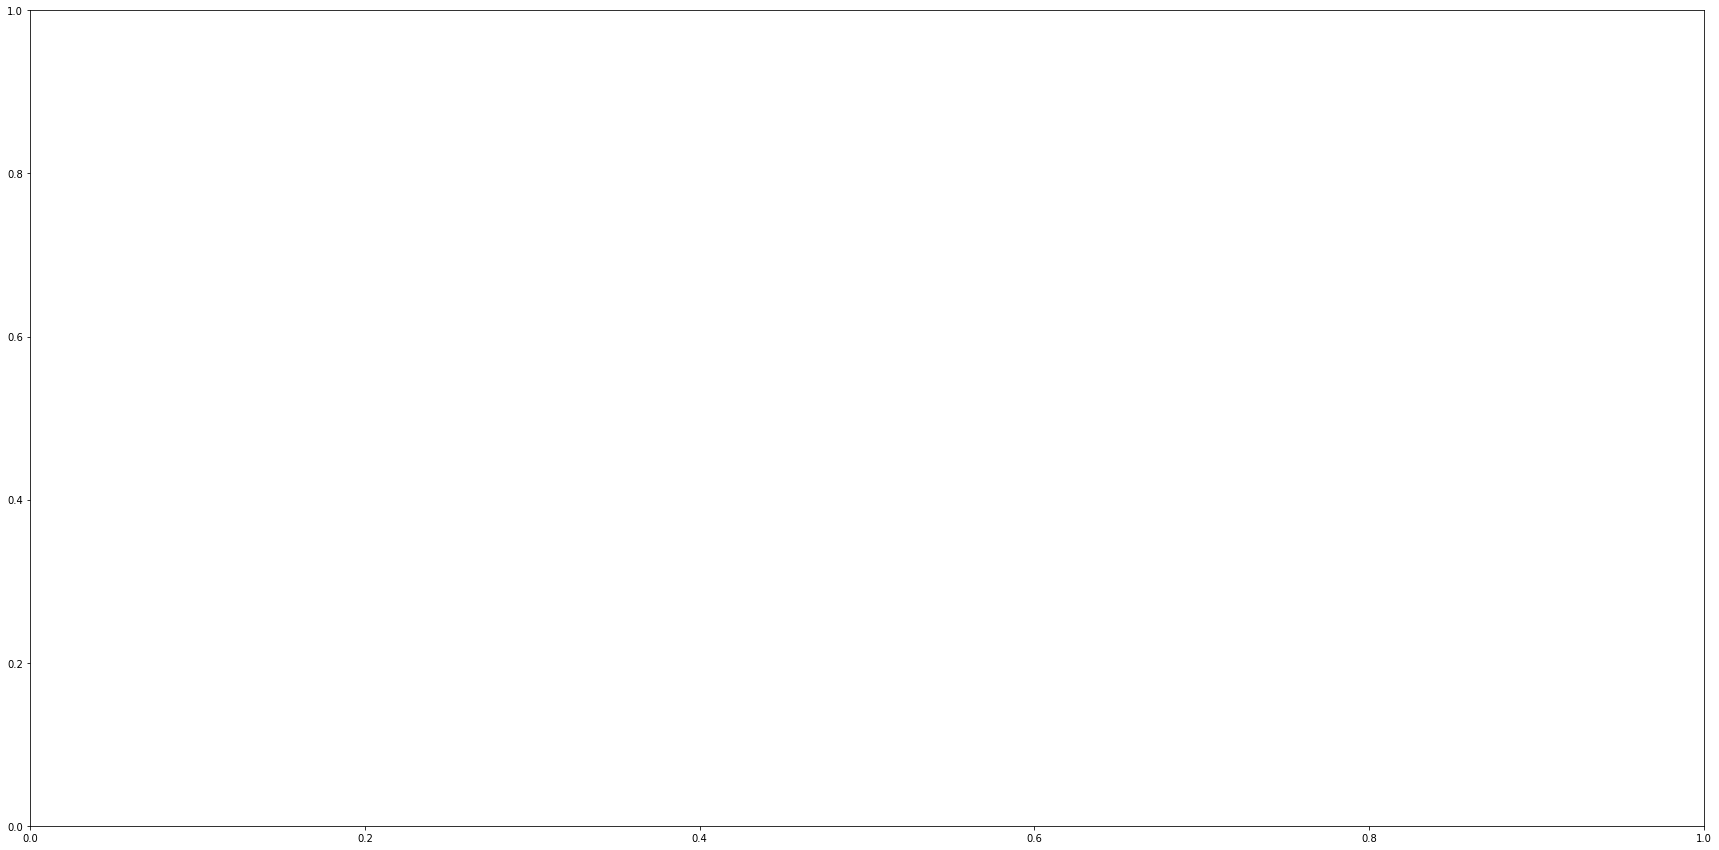

In [35]:
# plot analytical results
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(current,delta_omega_Im*T0,'rx-')
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))
fn_growth_rate = os.path.join(cwd,'growth_rate_analytical.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL,delta_omega_Im,'rx')
axes1.set_ylabel('Im(OMEGA)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.13f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_analytical_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [36]:
# iterative solver
def F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0):
    omegasamp = ((ps*nBunch+mu)*2*np.pi*f0+Omega)
    Zs = np.array([Zparallel(R[i],QL[i],omegac[i],omegasamp) for i in range(nRF)])
    factor = nBunch*NperBunch*r0*eta/(Gamma0*T0**2)
    return Omega**2-(1j*factor*np.sum(omegasamp*Zs)+(Qs*f0*2*pi)**2)

def SolveOmega(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,maxIter,accu):
    nIter = 0
    # initial values
    OmegaR = np.real(Omega)
    OmegaI = np.imag(Omega)
    # step size
    sig1 = 1
    sig2 = 1*1j
    Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
    
    while(np.abs(Err)>accu and nIter<maxIter):
        OmegaR = np.real(Omega)
        OmegaI = np.imag(Omega)
        Err = F(Omega,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0)
        F1 = F(Omega+sig1,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaRe by a small step
        F2 = F(Omega+sig2,ps,mu,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0) # change OmegaIm by a small step
        Fre = np.real(Err)
        Fim = np.imag(Err)
        F1re = np.real(F1)
        F1im = np.imag(F1)
        F2re = np.real(F2)
        F2im = np.imag(F2)
        # approximate the Jacobian
        dF11 = F1re-Fre
        dF12 = F2re-Fre
        dF21 = F1im-Fim
        dF22 = F2im-Fim
        
        det = dF11*dF22-dF12*dF21
        # inverse the Jacobian
        dF11inv = dF22/det
        dF12inv = -dF12/det
        dF21inv = -dF21/det
        dF22inv = dF11/det

        OmegaR -= Fre*dF11inv+Fim*dF12inv
        OmegaI -= Fre*dF21inv+Fim*dF22inv
        Omega = OmegaR+OmegaI*1j
        nIter += 1
    return Omega
    print(Omega)
    print(np.abs(Err))
    print(nIter)

In [37]:
# Iteratively solve:
qidx=0
delta_omega_Re_Iter = np.zeros(len(new_folders))
delta_omega_Im_Iter = np.zeros(len(new_folders))
mus = [-1]#[nBunch-1]
OMEAG_ini = [omegas*np.exp(1j*i/100*2*pi) for i in range(100)]
for folder in new_folders[:]:
    #print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    for i in mus:
        maxOMEGAIM = -1e360
        for Omega in OMEAG_ini:
            temp = SolveOmega(Omega,ps,i,nRF,R,QL,omegac,nBunch, NperBunch,r0,eta,Gamma0,T0,Qs,f0,200,1e-9)
            if np.imag(temp)>maxOMEGAIM:
                maxOMEGAIM = np.imag(temp)
                delta_omega_Re_Iter[qidx] = np.real(temp)
                delta_omega_Im_Iter[qidx] = np.imag(temp)
        print(qidx,';',delta_omega_Re_Iter[qidx]-omegas,delta_omega_Im_Iter[qidx])
    qidx+=1


0 ; 12704.19534084557 13.044226789203556
1 ; 12704.19534084557 13.044226789203556


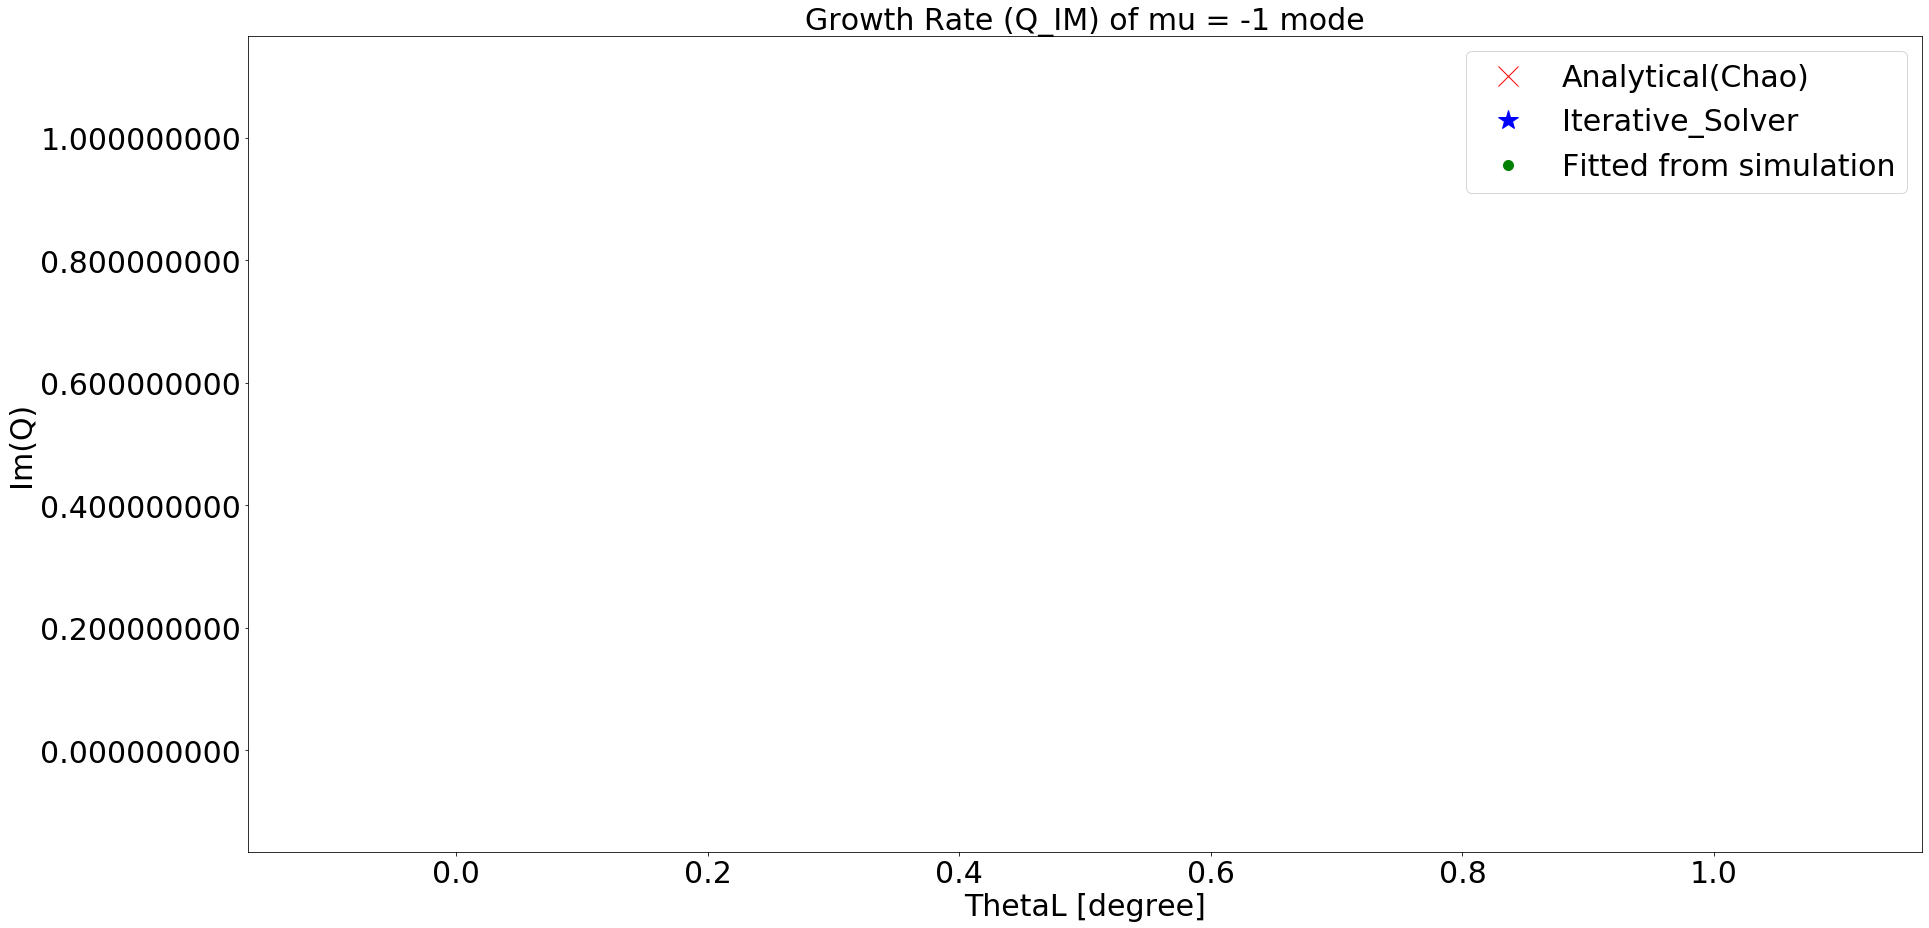

In [38]:
# plot the growth rate vs thetaL
os.chdir(home0)
cwd = os.getcwd()
rng1 = 1
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)

axes1.plot(thetaL[rng1:rng2],delta_omega_Im[rng1:rng2]*T0-T0/t_rad_long,'rx', ms = 20)
axes1.plot(thetaL[rng1:rng2],delta_omega_Im_Iter[rng1:rng2]*T0-T0/t_rad_long,'b*', ms = 20)
axes1.plot(thetaL[rng1:rng2],qs[rng1:rng2],'g.', ms = 20)

axes1.set_title('Growth Rate (Q_IM) of mu = -1 mode',fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.9f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

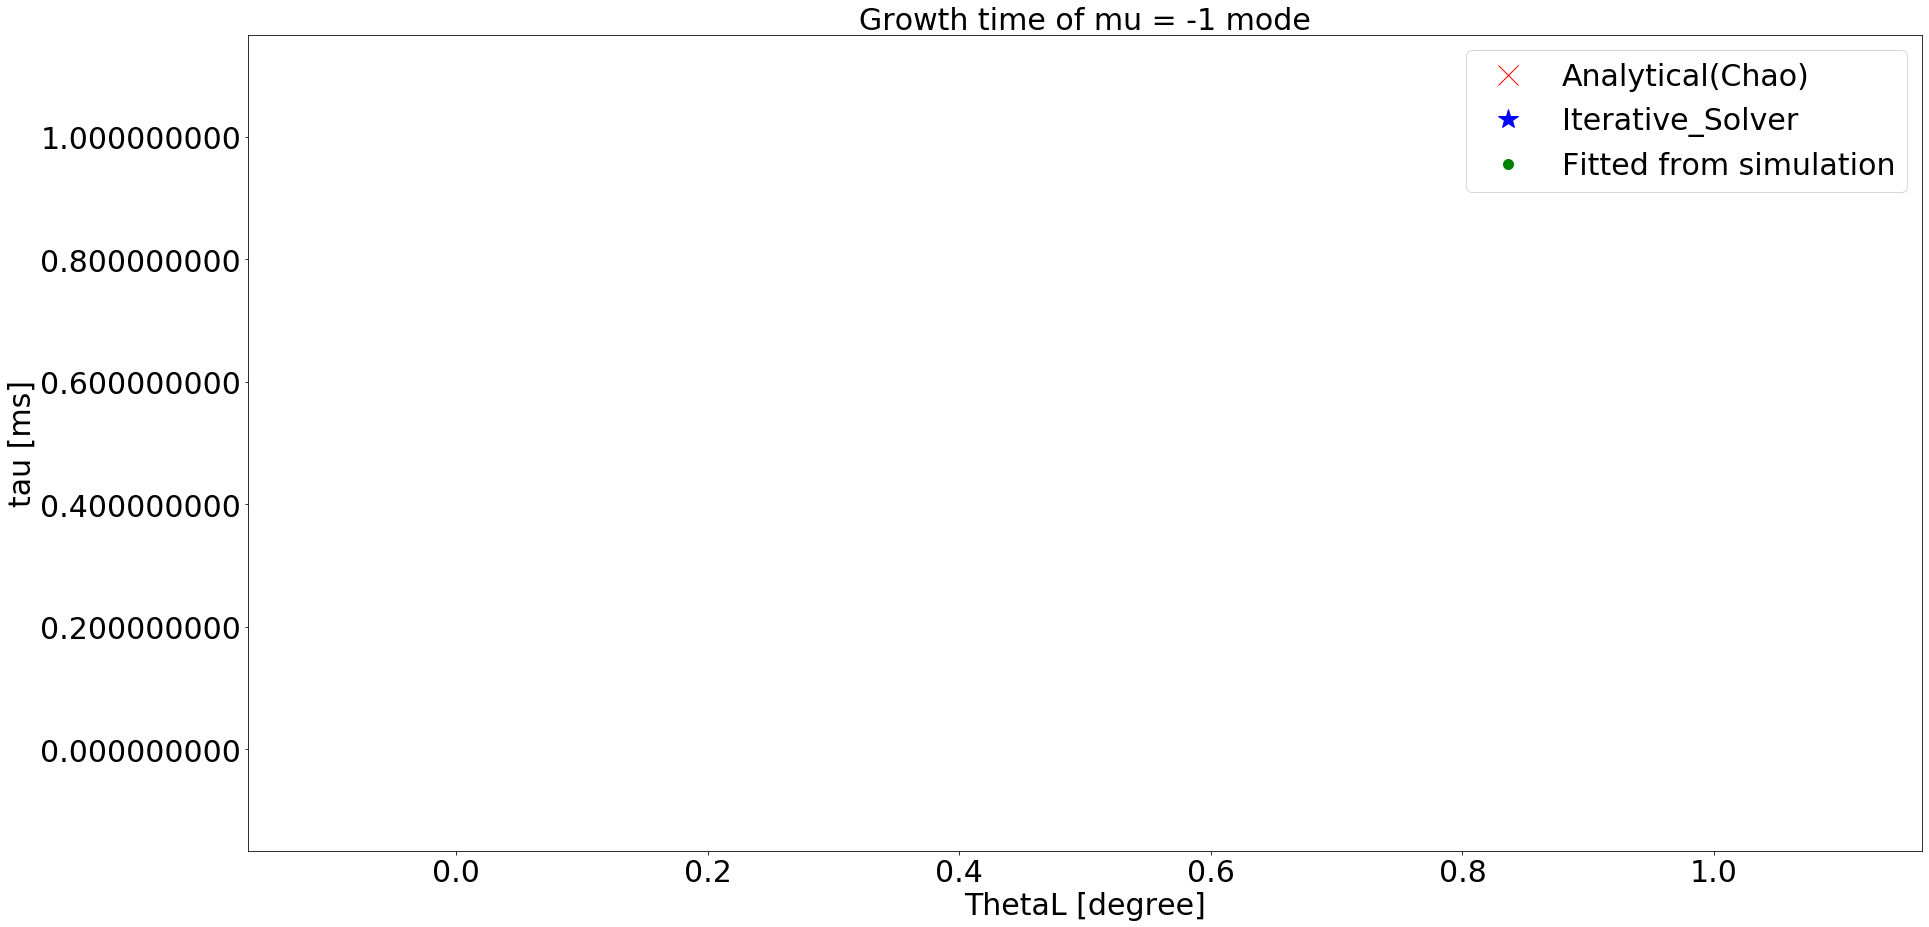

In [39]:
# plot the growth time vs thetaL
os.chdir(home0)
cwd = os.getcwd()
rng1 = 1
rng2 = len(thetaL)-1
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
axes1.plot(thetaL[rng1:rng2],1/delta_omega_Im[rng1:rng2],'rx', ms = 20)
axes1.plot(thetaL[rng1:rng2],1/delta_omega_Im_Iter[rng1:rng2],'b*', ms = 20)
axes1.plot(thetaL[rng1:rng2],1/(qs[rng1:rng2]/T0+1/t_rad_long),'g.', ms = 20)
#axes1.set_ylim([-1000,1000])
axes1.set_title('Growth time of mu = -1 mode',fontsize=30)
axes1.set_ylabel('tau [ms]',fontsize=30)
axes1.set_xlabel('ThetaL [degree]',fontsize=30)
axes1.legend(["Analytical(Chao)", "Iterative_Solver","Fitted from simulation"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.9f'))

fn_growth_rate = os.path.join(cwd,'growth_time_fit_analy_iter_vs_thetaL.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

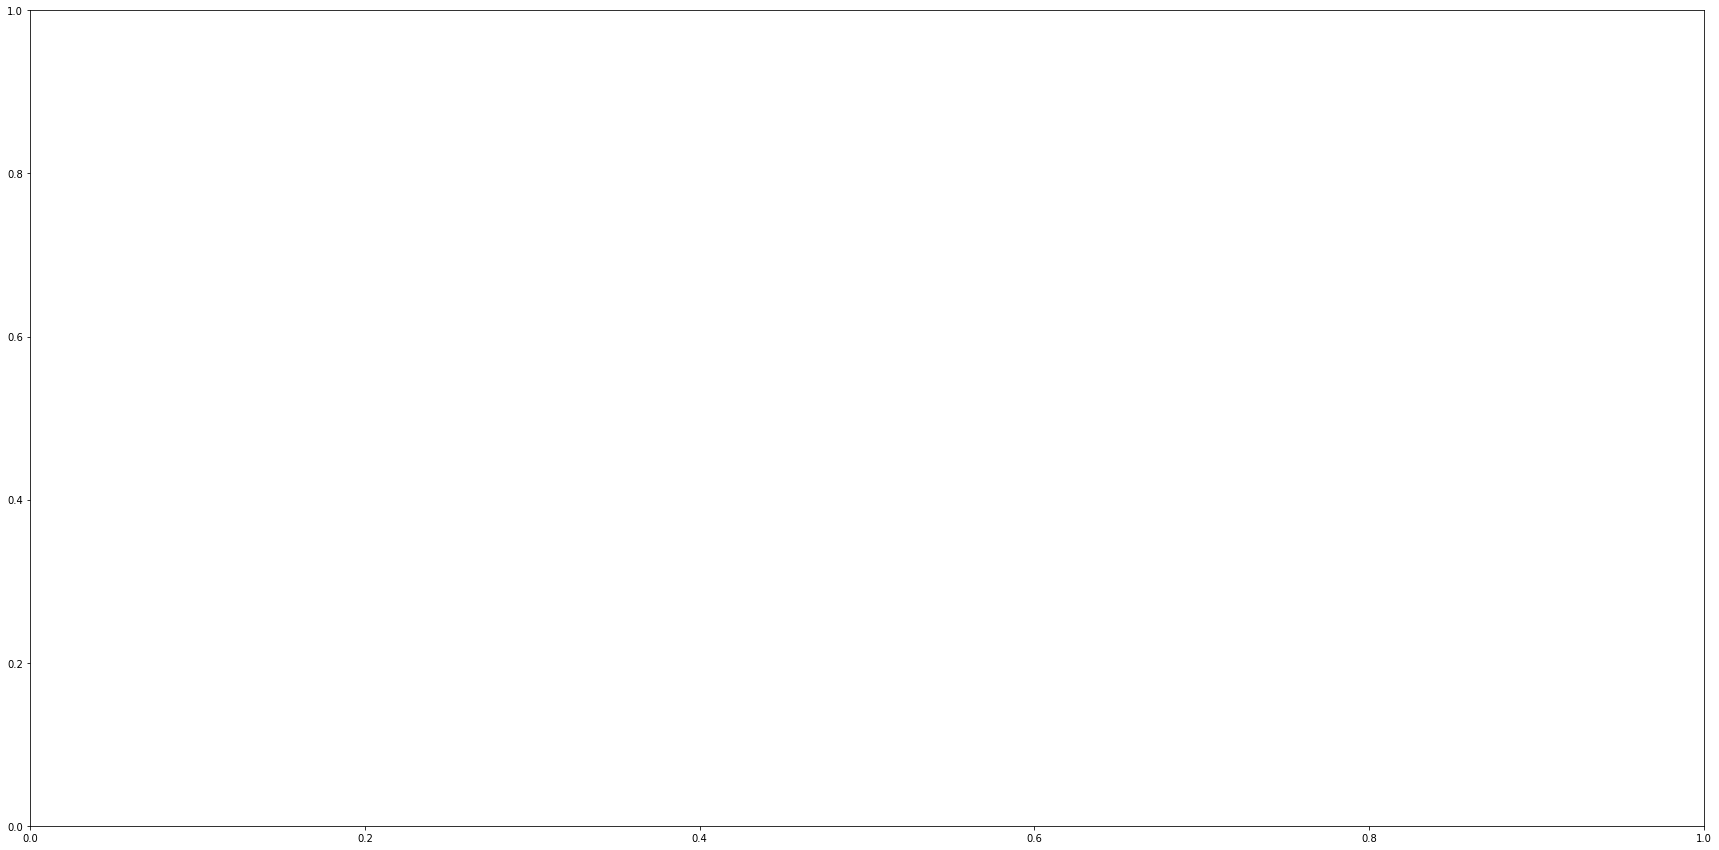

In [40]:
# plot the growth rate vs Ib
os.chdir(home0)
cwd = os.getcwd()
#current = [float(folder[21:25]) for folder in folders]
fig1,axes1 = plt.subplots(1,1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
rng1 = 0
rng2 = 50
axes1.plot(current[rng1:rng2],delta_omega_Im[rng1:rng2]*T0-T0/t_rad_long,'rx-')
axes1.plot(current[rng1:rng2],qs[rng1:rng2],'g.-', ms = 20)
axes1.plot(current[rng1:rng2],delta_omega_Im_Iter[rng1:rng2]*T0-T0/t_rad_long,'b*-')
axes1.axhline(y=0)

axes1.set_title('Growth Rate (Q_IM) of mu = -1 mode',fontsize=30)
axes1.set_ylabel('Im(Q)',fontsize=30)
axes1.set_xlabel('IbDC [A]',fontsize=30)
axes1.legend(["Analytical(Chao)","Fitted from simulation", "Iterative_Solver"],prop={'size': 30})
axes1.tick_params(labelsize=30)
#axes1.set_ylim([-0.001,0.001])
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.5f'))

fn_growth_rate = os.path.join(cwd,'growth_rate_fit_analy_iter.jpg')
plt.savefig(fn_growth_rate,bbox_inches='tight')
plt.show()

In [ ]:
# Plot Centroids
def get_the_turn_number(c,value):
    for i in range(len(c)):
        if c[i]>=value:
            return i
    return i

inputfn = 'input.txt'
datafn = 'data.bin'

N_mode = 3 # number of mode to look
mu_danger = 0 # the mode we think is the most dangers

centroids = [(i*fill_step+0.5)*Trf[mainRF] for i in range(nBunch)]
qs = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
taus = np.zeros(len(new_folders)) # to calculate the growth rate of mu=1
q_guess = 0.01
qidx = 0
folders.sort()
for folder in new_folders:
    print(folder)
    os.chdir(os.path.join(home1,folder))
    cwd = os.getcwd()
    inputfile = os.path.join(cwd,inputfn)
    tempinput = {}
    with open(inputfile) as inputfile:
        for line in inputfile:
            if len(line.split())>1:
                tempinput[line.split()[0]] = line.split()[1:]
    for i in tempinput:
        for j in range(len(tempinput[i])):
            tempinput[i][j] = float(tempinput[i][j])
    nRF = int(tempinput['nRF'][0])
    nRF1 = int(tempinput['nRF1'][0])
    nRF2 = int(tempinput['nRF2'][0])
    nRFc = int(tempinput['nRFc'][0])

    
    nTurns = int(tempinput['n_turns'][0])
    nfill = int(tempinput['n_fill'][0])
    n_q_ramp = int(tempinput['n_q_ramp'][0])
    NpRF = int(tempinput['N_bins'][0])
    h = [int(i) for i in tempinput['h']]
    detune_ini = np.array([i for i in tempinput['detune_ini']])
    detune_final = np.array([i for i in tempinput['detune_final']])

    step = int(tempinput['step_store'][0])
    fill_step = int(tempinput['fill_step'][0])
    nBeam = int(tempinput['nBeam'][0])
    beam_shift = int(tempinput['beam_shift'][0])
    nBunch = int(tempinput['n_bunches'][0])
    nPar = int(tempinput['Npar'][0])
    NperBunch = int(tempinput['NperBunch'][0])
    nTot = nBunch*nPar*nBeam
    Gamma0 = tempinput['Gamma'][0]
    Rring = tempinput['R'][0]
    n_record = nTurns/step
    beta = np.sqrt(1-1/Gamma0**2)
    T0 = 2*np.pi*Rring/(clight*beta)
    f0 = 1/T0
    V0 = [i for i in tempinput['Vref_I']]
    V0Q = [i for i in tempinput['Vref_Q']]
    II = [i for i in tempinput['Iref_I']]
    IQ = [i for i in tempinput['Iref_Q']]
    mainRF = int(tempinput['mainRF'][0])
    Pbeam = tempinput['Prad'][0]
    if int(tempinput['type'][0]==2):
        atomicZ = 79
        Ek = Gamma0*E0Au
    else:
        atomicZ =1
    if int(tempinput['type'][0]==1):  
        Ek = Gamma0*E0Elec

    GMTSQ = tempinput['GMTSQ'][0]
    Ek_damp = tempinput['Ek_damp'][0]

    eta = 1/GMTSQ-1/Gamma0**2
    if nRF ==1:
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
    elif nRF == 2 :
        Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

    omegarf = 2*np.pi*(np.array(h)*f0)
    omegac = 2*np.pi*(np.array(h)*f0+detune_final)
    Trf = 2*np.pi/omegarf
    RoQ = [i for i in tempinput['RoQ']]
    QL = [i for i in tempinput['QL']]
    R = [RoQ[i]*QL[i] for i in range(nRF)]

    Th = 2*np.pi/omegarf[0]
    dthat =Th/NpRF

    pattern = 'd'+'dd'*nBeam+3*nRF*'d'
    n_stride = 1+2*nBeam+3*nRF
    stride = len(pattern)*8
    test = array('d')
    bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

    M1_all = array('d')
    M1_fn = 'M1_all.bin'
    datafile = os.path.join(cwd,M1_fn)    
    with open(datafile, mode='rb') as file: # b is important -> binary
        M1_all.fromfile(file,2*nTurns*nBeam*nBunch)
    M1_1 = []
    M1_2 = []
    for i in range(nTurns):
        for j in range(nBunch):
            M1_1.append(M1_all[i*nBunch*2+j])
            M1_2.append(M1_all[i*nBunch*2+nBunch+j]-Gamma0)
    turns = np.array([i for i in range(nTurns*nBeam*nBunch)])

    
    fig1,axes1 = plt.subplots(1,1)
    fig1.set_figheight(10)
    fig1.set_figwidth(30)
    turns = 7000
    rng1 = turns*nBunch
    rng2 = rng1+nBunch
    axes1.plot((np.array(M1_1[rng1:rng2])-centroids)/Trf[0]*360,'rx-')
    
    axes1.set_ylabel('centroid (degree)',fontsize=30)
    fn_after = os.path.join(cwd,'Centroids.jpg')
    plt.savefig(fn_after,bbox_inches='tight')
    plt.show()
os.chdir(home0)